In [1]:
import rpy2
print(rpy2.__version__)

3.5.8


In [2]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

packnames = ('ggplot2', 'spam64')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

by .GlobalEnv when processing object ‘G’


In [5]:


import nibabel as nb
import numpy as np
 
# cifti code based on Christopher J Markiewicz https://nbviewer.jupyter.org/github/neurohackademy/nh2020-curriculum/blob/master/we-nibabel-markiewicz/NiBabel.ipynb
# load cifti file containing the vertexwise values, in this case myelin map from the HCP
cifti = nb.load('HCP_S900_787_tfMRI_ALLTASKS_level3_zstat1_hp200_s2_MSMSulc.dscalar.nii')
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr = cifti.header
nifti_hdr = cifti.nifti_header

axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]

def surf_data_from_cifti(data, axis, surf_name): 
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")

left_brain=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
left_brain=left_brain*-1 # Invert so we are looking at predicting from peaks of task negative

gifti_img_BaseBrain = nb.load('S900.L.sphere.32k_fs_LR.surf.gii')

xyz_points=gifti_img_BaseBrain.darrays[0].data





pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
import numpy as np

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

ptsnew=appendSpherical_np(xyz_points)

In [2]:
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.robjects import r, pandas2ri
import pandas as pd
import scipy
from sklearn.neighbors import DistanceMetric
from scipy import stats


pandas2ri.activate()

tasks=np.asarray([9,31,42,62,69,74,80])

LKPredAllTasks=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksAlt=np.zeros([tasks.shape[0],tasks.shape[0]])


LKPredAllTasksMinDist=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksAltMinDist=np.zeros([tasks.shape[0],tasks.shape[0]])

LKPredAllTasksTNRestrict=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksTNRestrictAlt=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksTNRestrictAltDiff=np.zeros([tasks.shape[0],tasks.shape[0]])

LKPredAllTasksTNeg=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksAltTNeg=np.zeros([tasks.shape[0],tasks.shape[0]])

LKPredAllTasksTNegNotCore=np.zeros([tasks.shape[0],tasks.shape[0]])
LKPredAllTasksAltTNegNotCore=np.zeros([tasks.shape[0],tasks.shape[0]])

for u in range(tasks.shape[0]):
    for v in range(tasks.shape[0]):
        print(u)
        #print(v)
        #if u !=v: 
        tasksCompare=np.array([u,v])
        NotZero1=np.abs(left_brain[:,tasks[tasksCompare[0]]])>0
        NotZero2=np.abs(left_brain[:,tasks[tasksCompare[1]]])>0
        threshTask1= np.percentile(left_brain[NotZero1,tasks[tasksCompare[0]]], 75, axis=0)
        threshTask2= np.percentile(left_brain[NotZero2,tasks[tasksCompare[1]]], 75, axis=0)

        pos_index=np.logical_and(left_brain[:,tasks[tasksCompare[0]]]>threshTask1,left_brain[:,tasks[tasksCompare[1]]]>threshTask2)
        neg_index=np.logical_not(left_brain[:,tasks[tasksCompare[0]]]>threshTask1,left_brain[:,tasks[tasksCompare[1]]]>threshTask2)
        
        
        task=tasks[tasksCompare[0]]

        LK = importr('LatticeKrig')


        X_temp=np.degrees(ptsnew[pos_index,4])

        X1=FloatVector(X_temp[:])

        X_temp=np.degrees(ptsnew[pos_index,5])

        X2=FloatVector(X_temp[:])
        Y_temp=left_brain[pos_index,task]

        Y=FloatVector(Y_temp[:])

        df = pd.DataFrame({'X1': X2, 'X2': X1})

        r_dataframe = pandas2ri.py2rpy(df)


        alpha=FloatVector(np.power([1,0.5,0.1],2))

        LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=1.01,alpha=alpha,LKGeometry="LKSphere",Radius=100) 

        LKOutput=LK.LatticeKrig(r_dataframe,Y,LKinfo=LKinfo)

        X1_all=FloatVector(np.degrees(ptsnew[:,4]))
        X2_all=FloatVector(np.degrees(ptsnew[:,5]))
        Y_all=FloatVector(left_brain[:,task])


        df_all = pd.DataFrame({'X1': X2_all, 'X2': X1_all})

        r_dataframe_all = pandas2ri.py2rpy(df_all)
        tempPredict=r.predict(LKOutput,r_dataframe_all).ravel()
        


        dist = DistanceMetric.get_metric('haversine')
        DistsToIncluded=dist.pairwise(ptsnew[pos_index,4:6],ptsnew[:,4:6])
        MinDists=DistsToIncluded.min(axis=0)
        LKPredAllTasks[u,v]=stats.spearmanr(tempPredict[np.logical_and(neg_index,MinDists>0.0)],left_brain[np.logical_and(neg_index,MinDists>0.0),tasks[u]])[0]
        LKPredAllTasksAlt[u,v]=stats.spearmanr(tempPredict[np.logical_and(neg_index,MinDists>0.0)],left_brain[np.logical_and(neg_index,MinDists>0.0),tasks[v]])[0]
        LKPredAllTasksMinDist[u,v]=stats.spearmanr(tempPredict[np.logical_and(neg_index,np.logical_and(MinDists>0.1,MinDists<1))],left_brain[np.logical_and(neg_index,np.logical_and(MinDists>0.1,MinDists<1)),tasks[u]])[0]
        LKPredAllTasksAltMinDist[u,v]=stats.spearmanr(tempPredict[np.logical_and(neg_index,np.logical_and(MinDists>0.1,MinDists<1))],left_brain[np.logical_and(neg_index,np.logical_and(MinDists>0.1,MinDists<1)),tasks[v]])[0]
     
        LKPredAllTasksTNRestrict[u,v]=stats.spearmanr(tempPredict[left_brain[:,tasks[u]]<0],left_brain[left_brain[:,tasks[u]]<0,tasks[u]])[0]
        LKPredAllTasksTNRestrictAlt[u,v]=stats.spearmanr(tempPredict[left_brain[:,tasks[u]]<0],left_brain[left_brain[:,tasks[u]]<0,tasks[v]])[0]
        LKPredAllTasksTNRestrictAltDiff[u,v]=stats.spearmanr(tempPredict[left_brain[:,tasks[v]]<0],left_brain[left_brain[:,tasks[v]]<0,tasks[v]])[0]
        
        a=tempPredict[neg_index].ravel()<0
        b=left_brain[neg_index,u].ravel()<0
        c=left_brain[neg_index,v].ravel()<0
        
        
        LKPredAllTasksTNeg[u,v]=np.logical_and(a,b).sum()
        LKPredAllTasksAltTNeg[u,v]=np.logical_and(a,c).sum()
        

by .GlobalEnv when processing object ‘G’


KeyboardInterrupt: 

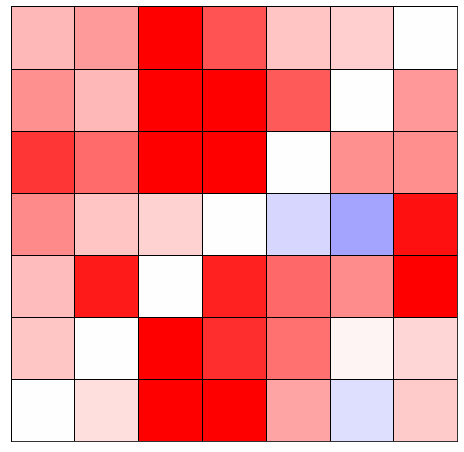

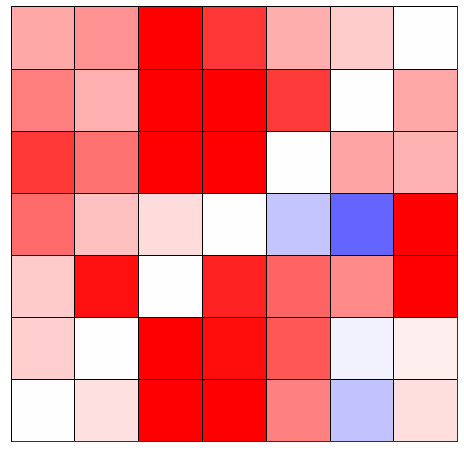

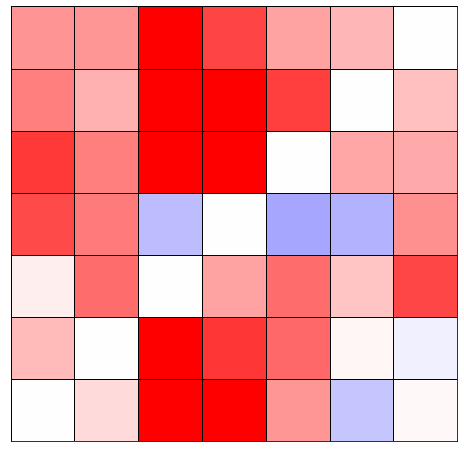

TtestResult(statistic=7.66013099637993, pvalue=1.9587428081901637e-09, df=41)
tfMRI_WM_0BK
TtestResult(statistic=2.2121899896193553, pvalue=0.03894478359178229, df=5)
TtestResult(statistic=1.7936845869929885, pvalue=0.06641664292349941, df=5)
TtestResult(statistic=1.933624928806241, pvalue=0.055486784961802045, df=5)
tfMRI_GAMBLING_REWARD
TtestResult(statistic=2.948424795199135, pvalue=0.015971777623585565, df=5)
TtestResult(statistic=2.3309690895741295, pvalue=0.033565121853632, df=5)
TtestResult(statistic=2.3732114947348575, pvalue=0.03184927631175473, df=5)
tfMRI_MOTOR_AVG
TtestResult(statistic=5.621572403316215, pvalue=0.0012330199388236936, df=5)
TtestResult(statistic=4.195947453796907, pvalue=0.004261387683845383, df=5)
TtestResult(statistic=5.191145279560561, pvalue=0.0017463510431444146, df=5)
tfMRI_LANGUAGE_MATH
TtestResult(statistic=1.1171195909128653, pvalue=0.15736412715508144, df=5)
TtestResult(statistic=0.6141665038337824, pvalue=0.2829857047348694, df=5)
TtestResult(stat

In [8]:

taskNames=np.loadtxt('TaskNames.txt',dtype=str,delimiter=',')


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))

plt.pcolormesh((LKPredAllTasks-LKPredAllTasksAlt), edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.savefig("TaskIntersectionTPPermuteAll.png", bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(8, 8))

plt.pcolormesh((LKPredAllTasksMinDist-LKPredAllTasksAltMinDist), edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.savefig("TaskIntersectionTPPermuteMinDist.png", bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 8))

plt.pcolormesh((LKPredAllTasksTNRestrict-LKPredAllTasksTNRestrictAlt), edgecolors='k', linestyle='-',linewidth=1,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.savefig("TaskIntersectionPermuteTPRestrict.png", bbox_inches='tight')
plt.show()

A=LKPredAllTasks
B=LKPredAllTasksAlt
print(stats.ttest_rel((A[~np.eye(A.shape[0],dtype=bool)]),((B[~np.eye(B.shape[0],dtype=bool)]))))

for i in range(7):
    print(taskNames[tasks[i]])
    print(stats.ttest_rel(np.delete(np.arctanh(LKPredAllTasks[i,:].ravel()),i),np.delete(np.arctanh(LKPredAllTasksAlt[i,:].ravel()),i),alternative='greater'))
    print(stats.ttest_rel(np.delete(np.arctanh(LKPredAllTasksTNRestrict[i,:].ravel()),i),np.delete(np.arctanh(LKPredAllTasksTNRestrictAlt[i,:].ravel()),i),alternative='greater'))
    print(stats.ttest_rel(np.delete(np.arctanh(LKPredAllTasksMinDist[i,:].ravel()),i),np.delete(np.arctanh(LKPredAllTasksAltMinDist[i,:].ravel()),i),alternative='greater'))




In [9]:
def write_plyRGB(filename, vertices, faces, colorsR,colorsG,colorsB,comment=None):
    import pandas as pd
    print("writing ply format")
    # infer number of vertices and faces
    number_vertices = vertices.shape[0]
    number_faces = faces.shape[0]
    # make header dataframe
    header = ['ply',
            'format ascii 1.0',
            'comment %s' % comment,
            'element vertex %i' % number_vertices,
            'property float x',
            'property float y',
            'property float z',
            'property uchar red',
            'property uchar green',
            'property uchar blue',
            'element face %i' % number_faces,
            'property list uchar int vertex_indices',
            'end_header'
             ]
    header_df = pd.DataFrame(header)
    # make dataframe from vertices
    vertex_df = pd.DataFrame(vertices/50)
    #colors_df = pd.DataFrame(np.tile(np.round(colors/7*255), (3,1)).T)
    ColorsR_df=pd.DataFrame(colorsR)
    ColorsG_df=pd.DataFrame(colorsG)
    ColorsB_df=pd.DataFrame(colorsB)
    colorsConcat = pd.concat([ColorsR_df,ColorsG_df,ColorsB_df], axis=1)
    colors_df=pd.DataFrame(colorsConcat)
    colors_df=colorsConcat.astype(int)
    df_concat = pd.concat([vertex_df, colors_df], axis=1)
    # make dataframe from faces, adding first row of 3s (indicating triangles)
    triangles = np.reshape(3 * (np.ones(number_faces)), (number_faces, 1))
    triangles = triangles.astype(int)
    faces = faces.astype(int)
    faces_df = pd.DataFrame(np.concatenate((triangles, faces), axis=1))
    # write dfs to csv
    header_df.to_csv(filename, header=None, index=False)
    with open(filename, 'a') as f:
        df_concat.to_csv(f, header=False, index=False,
                         float_format='%.3f', sep=' ')
    with open(filename, 'a') as f:
        faces_df.to_csv(f, header=False, index=False,
                        float_format='%.0f', sep=' ')

In [34]:

import  matplotlib.cm
#cmap = matplotlib.cm.get_cmap('bwr')

gifti_img_Midthickness = nb.load('S900.L.midthickness_MSMAll.32k_fs_LR.surf.gii')
vertices=gifti_img_Midthickness.darrays[0].data
faces=gifti_img_Midthickness.darrays[1].data
cmap = matplotlib.cm.get_cmap('bwr')
norm = matplotlib.colors.Normalize(vmin=-35.5, vmax=35.5)
colors=norm(left_brain[:,0]*-1)#/7#*254+1
CMap=cmap(colors)*255


write_plyRGB('MRITask.ply',vertices,faces,CMap[:,0],CMap[:,1],CMap[:,2])



writing ply format


-25.641764

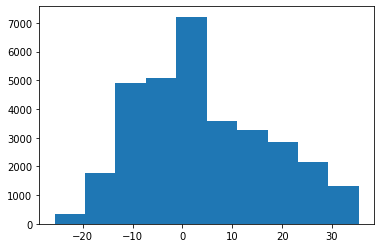

In [35]:
import matplotlib.pyplot as plt
plt.hist(left_brain[:,0]*-1)
(left_brain[:,0]*-1).min()